<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [37]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join("/homes/55/bwilop/wsg/private/", "vscode-ssh.env"))
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)
WANDB_ENTITIY = "benwilop-rwth-aachen-university"

data_folder = "/homes/55/bwilop/wsg/data/"
experiment_folder = "/homes/55/bwilop/wsg/experiments/"
crosscoder_folder = experiment_folder + "tictactoe/crosscoder/"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc


In [38]:
%load_ext autoreload
%autoreload 2
import json
import torch as t

from jaxtyping import Float
import matplotlib.pyplot as plt

from wsg_games.meta import *

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
print(DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# Load Data & Models

In [39]:
project_name_pretrain = "tictactoe/tictactoe_pretraining5"
project_name_finetune = "tictactoe/tictactoe_finetuning5"
weak_model_size = "small"
strong_model_size = "medium"
index = 2

# Load data
(
    tictactoe_train_data,
    tictactoe_weak_finetune_data,
    tictactoe_val_data,
    tictactoe_test_data,
) = load_split_data(data_folder + "tictactoe/", device=DEVICE, index=index)

# Load models
weak_model = load_model(
    project_name_pretrain,
    weak_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_baseline_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.STRONG_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
finetuned_model = load_finetuned_model(
    project_name_finetune,
    weak_model_size,
    strong_model_size,
    experiment_folder,
    DEVICE,
    index,
)

# Print evaluations
(
    weak_loss,
    _,
) = quick_evaluation("weak_model", weak_model, tictactoe_test_data)
strong_baseline_loss, _ = quick_evaluation(
    "strong_baseline_model", strong_baseline_model, tictactoe_test_data
)
quick_evaluation("strong_model", strong_model, tictactoe_test_data)
weak_finetuned_loss, _ = quick_evaluation(
    "finetuned_model", finetuned_model, tictactoe_test_data
)
print(
    "Performance Gap Recovered (PGR): ",
    (weak_loss - weak_finetuned_loss) / (weak_loss - strong_baseline_loss),
)

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_small_weak_2025-05-16-16-35_ayyrg2xq.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_weak_2025-05-16-16-35_eif67e03.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to

In [40]:
from dictionary_learning.dictionary_learning.cache import *
from wsg_games.tictactoe.crosscoder.collect_activations import *
from wsg_games.tictactoe.crosscoder.crosscoder_metrics import *
from wsg_games.tictactoe.crosscoder.train_crosscoder import *

In [41]:
# Strong
strong_train_activations_path, strong_val_activations_path = compute_activations(
    Game.TICTACTOE,
    Goal.STRONG_GOAL,
    project_name_pretrain,
    None,
    None,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
    device=DEVICE,
)

# Finetuned
finetuned_train_activations_path, finetuned_val_activations_path = compute_activations(
    Game.TICTACTOE,
    None,
    None,
    weak_model_size,
    project_name_finetune,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
    device=DEVICE,
)

print("strong_train_activations_path", strong_train_activations_path)
print("strong_val_activations_path:", strong_val_activations_path)
print("finetuned_train_activations_path:", finetuned_train_activations_path)
print("finetuned_val_activations_path:", finetuned_val_activations_path)

# Verify

for layer in range(4):
    validate_activations(
        [
            strong_train_activations_path + f"/layer_{layer}_out",
            finetuned_train_activations_path + f"/layer_{layer}_out",
        ]
    )
    validate_activations(
        [
            strong_val_activations_path + f"/layer_{layer}_out",
            finetuned_val_activations_path + f"/layer_{layer}_out",
        ]
    )

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_train
Instead, you can set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_val
Instead, you can set overwrite=True to overwrite existing shards.
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_finetuned_through_small_train
Instead, you can set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/act

In [42]:
layer = 3

model_0_name = "strong_model"
model_1_name = "finetuned_model"

train_activations_stor_dir_model_0 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_0 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "val"
)
train_activations_stor_dir_model_1 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_1 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "val"
)
training_cfg_cross_coder = get_training_cfg_cross_coder()
# train_crosscoder(
#     model_0_name,
#     model_1_name,
#     index,
#     train_activations_stor_dir_model_0 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_0 + f"/layer_{layer}_out",
#     train_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     layer,
#     training_cfg_cross_coder,
#     WANDB_ENTITIY,
#     DEVICE,
#     crosscoder_folder,
# )

Create activation histograms:   0%|          | 0/554 [00:00<?, ?it/s]

Activation histograms plot saved to /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-31-10-35/activation_histograms.png


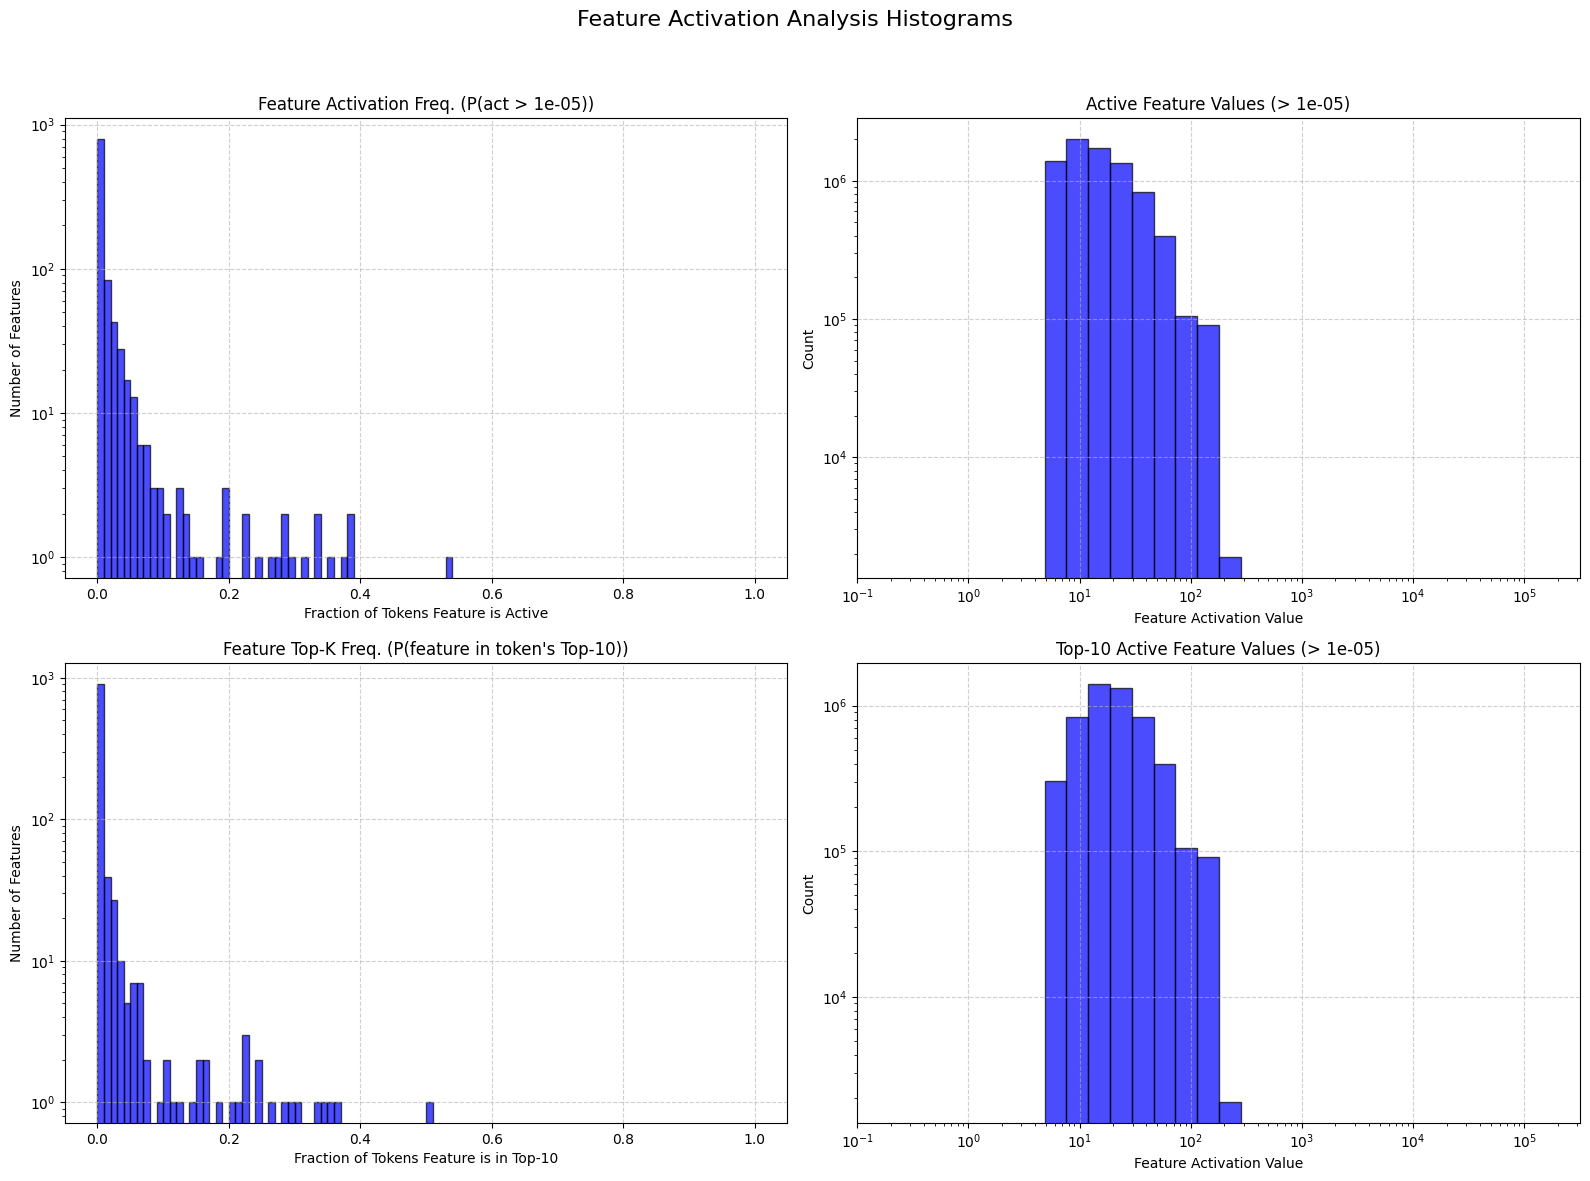

In [53]:
save_dir = "/homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-31-10-35"
crosscoder_metrics = CrosscoderMetrics(save_dir, DEVICE)

In [ ]:
crosscoder_metrics.top_n_activations

{0: [[10, 5, 0, 8], [10, 5, 0, 2, 1, 3], [10, 5, 0, 2], [10, 5, 0, 2, 7, 3]],
 1: [[10, 8, 3, 1, 7],
  [10, 8, 3, 1],
  [10, 6, 1, 3, 7],
  [10, 3, 6, 1, 8],
  [10, 3, 6, 8, 7, 5],
  [10, 3, 6, 5, 1, 7],
  [10, 3, 6, 8, 0, 7]],
 2: [[10, 8], [10, 5]],
 3: [[10, 5, 0, 4, 6],
  [10, 6, 1, 5, 8, 0],
  [10, 6, 1, 0, 4, 5],
  [10, 5, 0, 6]],
 4: [],
 5: [[10, 6, 1, 8, 7, 3],
  [10, 8, 3, 2, 6, 7, 5],
  [10, 8, 3, 2, 5, 7, 6],
  [10, 8, 3, 7, 5, 2, 6]],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [[10, 5, 0, 4, 3, 6, 8],
  [10, 4, 2, 6, 8, 1, 3],
  [10, 5, 0, 7, 3, 6, 8],
  [10, 6, 1, 4, 0, 7, 3],
  [10, 5, 0, 7, 1, 6, 3],
  [10, 5, 0, 4, 3, 7, 8],
  [10, 4, 2, 1, 3, 6, 8],
  [10, 4, 2, 1, 8, 6, 0],
  [10, 5, 0, 1, 8, 4, 3]],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [[10, 8, 3, 1, 0, 6],
  [10, 5, 0, 4],
  [10, 5, 0, 8, 4, 7],
  [10, 4, 2, 0, 8],
  [10, 5, 0, 7],
  [10, 5, 0, 7, 3, 2, 6, 9],
  [10, 4, 2, 0, 3],
  [10, 8, 3, 5, 0, 6],
  [10, 5, 0, 2, 3, 7, 6, 9]],
 17: [],
 18: [[10, 6, 1, 